In [48]:
import sympy as sp
import numpy as np
from scipy.integrate import odeint
from matplotlib import pyplot as plt
%matplotlib inline

Trying some sympy:

In [49]:
alpha, beta, gamma, theta, mu = 0.1, 0.1, 2.5, 0.05, 0.15
v0, v1, v2, v3, v4, v5, v6, v7, v8, v9 = sp.symbols('v0, v1, v2, v3, v4, v5, v6, v7, v8, v9')
unk = [v0, v1, v2, v3, v4, v5, v6, v7, v8, v9]

eqns = [-v0 + (1 + alpha)*v1 + v2,
       -v2 + 3/2*v3 + 3/4*v9,
       -v3 + v4 + v5,
       -3*v5 + 6/5*v6 + 6/4*v7,
       -v9 + -v7 + 2*v5,
       -theta - gamma*v1 + 1/3*v2 - 1/4*v9 + 1/8*v7 + 3*v8,
       beta*v1 + 1/3*v2 + 1/2*v3 - 1/2*v4 + v7 - 2*v8,
       mu - v1,
       v4,
       v7]

flux1 = sp.solve(eqns,unk)
flux1

{v4: 0.0,
 v8: 0.117272727272727,
 v3: 0.146363636363636,
 v1: 0.150000000000000,
 v2: 0.439090909090909,
 v7: 0.0,
 v6: 0.365909090909091,
 v0: 0.604090909090909,
 v5: 0.146363636363636,
 v9: 0.292727272727273}

In [50]:
eqns[-1] = v6

flux2 = sp.solve(eqns,unk)
print ('Respiration vs Itaconic production')
print ('Oxygen usage = ' ,flux2[v8]/flux1[v8])
print ('Glucose usage = ' ,flux2[v0]/flux1[v0])
flux2

Respiration vs Itaconic production
Oxygen usage =  1.04457364341085
Glucose usage =  0.463506395786306


{v4: 0.0,
 v8: 0.122500000000000,
 v3: 0.0766666666666667,
 v1: 0.150000000000000,
 v2: 0.115000000000000,
 v7: 0.153333333333333,
 v6: 0.0,
 v0: 0.280000000000000,
 v5: 0.0766666666666667,
 v9: 0.0}

In [51]:
eqns = [-v0 + (1 + alpha)*v1 + v2,
       -v2 + 3/2*v3 + 3/4*v9,
       -v3 + v4 + v5,
       -3*v5 + 6/5*v6 + 6/4*v7,
       -v9 + -v7 + 2*v5,
       -theta - gamma*v1 + 1/3*v2 + 1/8*v7 + 3*v8,
       beta*v1 + 1/3*v2 + 1/2*v3 - 1/2*v4 + v7 - 2*v8,
       mu - v1,
       v4,
       v7]

flux1 = sp.solve(eqns,unk)
flux1

eqns[-1] = v6

flux2 = sp.solve(eqns,unk)
print ('Respiration vs Itaconic production')
print ('Oxygen usage = ' ,flux2[v8]/flux1[v8])
print ('Glucose usage = ' ,flux2[v0]/flux1[v0])


Respiration vs Itaconic production
Oxygen usage =  1.22030651340996
Glucose usage =  0.521863799283154


In [52]:
def rates(C):
    Cx, Cs , Ci = C[0],C[1],C[2]
#     mu = mu_max * Cs / (Km + Cs) * (1 - Ce / Cemax)
#     if mu < 0:
#         mu = 0
#     theta = theta_max * Cs / (Km + Cs)
    
    ro_mt = kla * Co_sat
    
    eqns = [-v0 + (1 + alpha)*v1 + v2,
       -v2 + 3/2*v3 + 3/4*v9,
       -v3 + v4 + v5,
       -3*v5 + 6/5*v6 + 6/4*v7,
       -v9 + -v7 + 2*v5,
       -theta - gamma*v1 + 1/3*v2 + 1/8*v7 + 3*v8,
       beta*v1 + 1/3*v2 + 1/2*v3 - 1/2*v4 + v7 - 2*v8,
       mu - v1,
       v4,
       v6]

    flux = sp.solve(eqns,unk)
    
    if ro_mt > flux[v8]*Cx:

        return [flux[v1],
                -flux[v0],
                 flux[v6]]
    else:
        eqns[-1] = v8 - ro_mt/Cx
        flux = sp.solve(eqns,unk)
        return [flux[v1],
                -flux[v0],
                 flux[v6]]

In [53]:
def dNdt(C,t):
    Cx, Cs , Ci = C[0],C[1],C[2]
    r=rates(C)     

    return [r[0]*Cx,
            r[1]*Cx,
            r[2]*Cx,]     

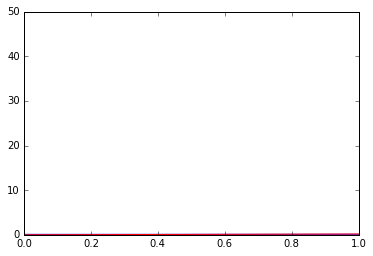

In [55]:
Cxo,Cso,Cio = 0.1,50,0
Co_sat = 7 / 1000 / 32  # mol O2 per liter
kla = 2
C = [Cxo,Cso,Cio]
T = 1

tspan = np.linspace(0,T,2)
Cans = odeint(dNdt,C,tspan)
plt.plot(tspan,Cans)

Thats far too slow, lets try numpy:

In [56]:
def dNdt(C,t):
    Cx, Cs , Ci ,Cco, Co, res, atp = C[0],C[1],C[2],C[3],C[4],C[5],C[6]
    r=rates(C,t)     
#     if r[5] < 0:
#         print ('Res = ',t,r[5])
#     if r[2] == 0:
#         print ('IA = ',t)
    return [r[0]*Cx,
            r[1]*Cx,
            r[2]*Cx,
           r[3]*Cx,
           r[4]*Cx,
           r[5]*Cx,
           r[6]*Cx]  

Sbase = np.matrix([[-1,1.1,1,1,0,0,0],
                     [0,0,0,-1,1.5,1.2,0],
                     [0,0.1,2,1/3,-0.5,0.2,-2],
                     [0,-2.5,0.5,1/3,0,-0.2,3]])

et_spec=[0,0,0,0,1,0,0]
ox_spec=[0,0,0,0,0,0,1]
res_spec=[0,0,1,0,0,0,0]
ita_spec=[0,0,0,0,0,1,0]
mu_spec=[0,1,0,0,0,0,0]
s_spec=[1,0,0,0,0,0,0]

mu_max = 0.05
theta_max = 0.1
Km_mu, Km_theta = 30/1000/30, 5/1000/30

def rates(C,t):
    Cx, Cs , Ci ,Cco, Co, Res, Atp  = C[0],C[1],C[2],C[3],C[4],C[5],C[6]
    mu = mu_max * Cs / (Km_mu + Cs)
    if mu < 0:
        mu = 0
    theta = theta_max * Cs / (Km_theta + Cs)
    
    ro_mt = kla * Co_sat
    cnt = 0

    eqn = np.vstack([Sbase,et_spec,ita_spec,mu_spec])  #Stoich matrix with specs included
    spec = np.matrix([[0,0,0,theta, 0, 0, mu]]).T    #zero ethanol and respiration
    flux = np.linalg.solve(eqn,spec) 
#     print (ro_mt)
    if ro_mt > flux[6,0]*Cx:
        return [flux[1,0],
                -mu,
                 flux[5,0],
               flux[2,0] + 1/5*flux[5,0] + alpha*flux[1,0],
               flux[6,0],
               flux[2,0],
               0.5*flux[2,0]  + 1/3*flux[3,0] -0.2*flux[5,0] + 3* flux[6,0]]
    else:
        eqn = np.vstack([Sbase,et_spec,ox_spec,mu_spec])  #Stoich matrix with specs included
        spec = np.matrix([[0,0,0,theta, 0,ro_mt/Cx , mu]]).T    #zero ethanol and respiration
        flux = np.linalg.solve(eqn,spec) 
        cnt = 1

        if flux[2,0] < 0:
            cnt = 2
            eqn = np.vstack([Sbase,et_spec,ox_spec,res_spec])  #Stoich matrix with specs included
            spec = np.matrix([[0,0,0,theta, 0,ro_mt/Cx , 0]]).T    #zero ethanol and respiration
            flux = np.linalg.solve(eqn,spec) 

#         if cnt == 2:
#             print (t)
        return [flux[1,0],
                -mu,
                 flux[5,0],
               flux[2,0] + 1/5*flux[5,0] + alpha*flux[1,0],
               flux[6,0],
               flux[2,0],
                0.5*flux[2,0]  + 1/3*flux[3,0] -0.2*flux[5,0] + 3* flux[6,0]]
    
    if flux[2,0] > 0 and flux[5,0] > 0:
        print (t)

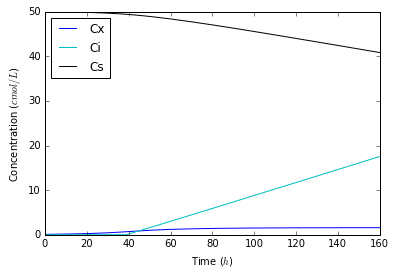

T =  55.448975803


In [59]:
Cxo,Cso,Cio,Cco,Co, res,atp = 0.1,50,0,0,0,0,0
Co_sat = 7 / 1000 / 32  # mol O2 per liter
kla = 200
C = [Cxo,Cso,Cio,Cco, Co,res,atp]
T = 160
leng = T*101
tspan = np.linspace(0,T,leng)
Cans = odeint(dNdt,C,tspan)
Cx,Cs,Ci,Cco,Co,res,atp = Cans.T
plt.figure()
plt.plot(tspan, Cx, 'b', label='Cx')
plt.plot(tspan, Ci, 'c', label='Ci')
plt.plot(tspan, Cs, 'k', label='Cs')
plt.xlabel('Time ($h$)')
plt.ylabel('Concentration ($cmol/L$)')
plt.ylim(0)
# Cxo,Cso,Cio,Cco,Co, res = 0.1,50,0,0,0,0
# Co_sat = 7 / 1000 / 32  # mol O2 per liter
# kla = 200
# C = [Cxo,Cso,Cio,Cco, Co,res]
# T = 100
# Cans1 = odeint(dNdt,C,tspan)
# Cx1,Cs,Ci2,Cco,Co,res = Cans1.T
# plt.plot(tspan, Cx1, 'r', label='Cx')
# # plt.plot(tspan, Cs,'r', label='Cs')
# plt.plot(tspan, Ci2, 'g', label='Ci')
# # plt.plot(tspan, Cco, 'k', label='Cco2')
plt.legend(loc = 'best')

plt.savefig('conc.png')
plt.show()
print ('T = ',tspan[5600])

Far better!

It can be seen from the graph above that respiration is functioning for the first half of the fermentation while oxygen is not
limiting however once the biomass concentration increases the oxygen per cell decreases and oxgen becomes limiting.

This is then shown by the production of Itaconic acid and the increased consumption rate of glucose.

In [33]:
def rate(C,t):
        r = rates(C,0)
        return r


C = Cx, Cs, Ci, Cco, Co,res, atp
Mu = [rate([Cxi, Csi, Cii, Ccoi, Coi,resi,atpi],t ) for Cxi, Csi, Cii, Ccoi,Coi,resi,atpi,t in zip(Cx, Cs, Ci, Cco, Co,res,atp,tspan)]


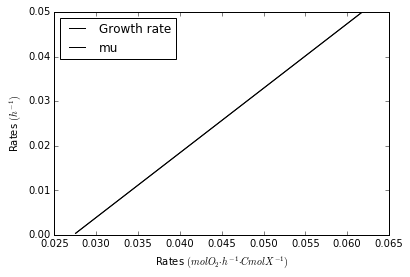

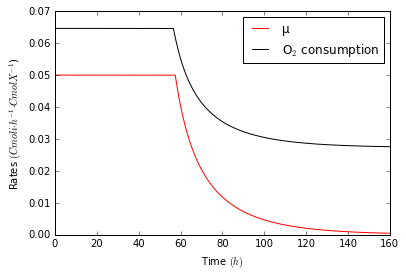

In [61]:
rate = np.array(Mu)
rx,rs,ri,rco,ro,rres,ratp = rate.T
Yoatp = ratp/ro
plt.plot(ro,rx,'k',label = "Growth rate")
plt.plot(ro,rx,'k',label = "mu")
# plt.plot(tspan,rate[:,1], 'c--',label = "Glucose rate")
# plt.plot(tspan,rate[:,2], 'r--',label = "IA rate")

# plt.plot(tspan,rates[:,3])
plt.legend(loc = 'best')
# plt.ylim(ymin = 0)
plt.ylabel('Rates $( h^{-1})$')
plt.xlabel('Rates $(mol O_2 \xB7 h^{-1} \xB7 CmolX^{-1})$')

plt.show()


plt.figure()
plt.plot(tspan,rx, 'r',label = "µ")
plt.plot(tspan,ro, 'k',label = "O$_2$ consumption")
plt.ylabel('Rates $(Cmoli \xB7 h^{-1} \xB7 CmolX^{-1}$)')
plt.xlabel('Time $(h)$')
plt.legend(loc = 'best')
plt.savefig('o2mu.png')
plt.show()

# plt.plot(tspan,rate[:,5], 'r',label = "Respiration rate")
# plt.ylabel('Rates $(Cmoli \xB7 h^{-1} \xB7 CmolX^{-1}$)')
# plt.xlabel('Time $(h)$')
# plt.legend(loc = 'best')
# plt.show()

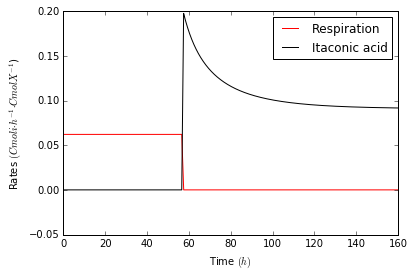

In [70]:
s,e = 0,-1
plt.figure()
plt.plot(tspan[s:e],rres[s:e],'r',label = "Respiration")
plt.plot(tspan[s:e],ri[s:e],'k',label = "Itaconic acid")
plt.legend(loc = 'best')
plt.ylabel('Rates $(Cmoli \xB7 h^{-1} \xB7 CmolX^{-1}$)')
plt.xlabel('Time $(h)$')
plt.xlim(0)
plt.savefig('phases.png')
plt.show()


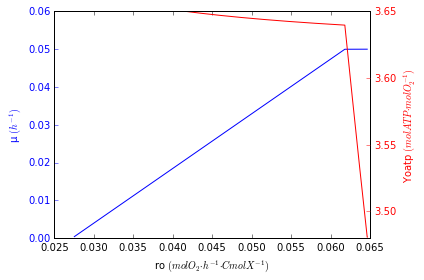

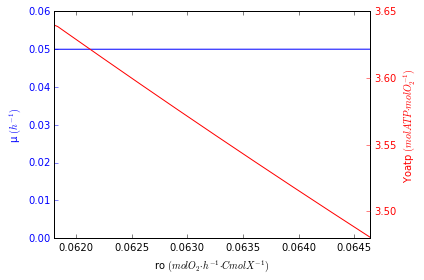

In [71]:

plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(ro[s:e], rx[s:e], 'b-')
ax1.axis(ymin = 0,ymax= 0.06)
ax1.set_xlabel('ro $(mol O_2 \xB7 h^{-1} \xB7 CmolX^{-1})$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('µ $(h^{-1})$', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.axis(ymin = 3.48,ymax= 3.65)
ax2.plot(ro[s:e], Yoatp[s:e], 'r')
ax2.set_ylabel('Yoatp $(mol ATP \xB7 mol O_2^{-1})$ ', color='r')
ax2.tick_params('y', colors='r')

fig.tight_layout()
plt.savefig("full.png")
plt.show()

plt.figure()
fig, ax1 = plt.subplots()
ax1.plot(ro[s:e], rx[s:e], 'b-')
ax1.axis(ymin = 0,ymax= 0.06)
ax1.set_xlabel('ro $(mol O_2 \xB7 h^{-1} \xB7 CmolX^{-1})$')
# Make the y-axis label, ticks and tick labels match the line color.
ax1.set_ylabel('µ $(h^{-1})$', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()
ax2.axis(ymin = 3.48,ymax= 3.65)
ax2.plot(ro[s:e], Yoatp[s:e], 'r')
ax2.set_ylabel('Yoatp $(mol ATP \xB7 mol O_2^{-1})$ ', color='r')
ax2.tick_params('y', colors='r')
plt.xlim([ro[5804],ro[5600]])
fig.tight_layout()
plt.savefig('zoom.png')
plt.show()